In [247]:
import pandas as pd
df = pd.read_csv('./course-catalog.csv')

# Drop unnecessary columns
# We only need the Subject, Number, Description
df =df[['Subject', 'Number', 'Description']]
# Drop duplicates
df = df.drop_duplicates()
#fill NaN values with empty string
df = df.fillna('')
df.head(10)


,Subject,Number,Description
0,AAS,100,"Interdisciplinary introduction to the basic concepts and approaches in Asian American Studies. Surveys the various dimensions of Asian American experiences including history, social organization, literature, arts, and politics."
11,AAS,200,"Invites students to examine histories and narratives of U.S. race and empire, drawing upon multiple theoretical and methodological works in Asian American studies and related fields. Same as LLS 200."
12,AAS,201,"Same as AFRO 201, LLS 201, and PS 201. See PS 201."
15,AAS,275,Same as GWS 275. See GWS 275.
23,AAS,283,Same as HIST 283. See HIST 283.
24,AAS,286,Same as ENGL 286. See ENGL 286.
25,AAS,297,Same as HDFS 221 and SOCW 297. See SOCW 297.
27,AAS,300,"Explores theories for performing interdisciplinary, intersectional and comparative studies within the field of Asian American studies. Follows multiple genealogies of critical work in ethnic and American studies. Same as GWS 305 and LLS 305."
28,AAS,310,"Same as AFRO 310, EPOL 310, EPS 310, and LLS 310. See EPOL 310."
32,AAS,355,Same as LLS 355 and SOC 355. See LLS 355.


In [248]:
#remove punctuation and numbers, lowercase
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# lowercase
df['Description'] = df['Description'].apply(lambda x: x.lower())
# remove punctuation and numbers
df['Description'] = df['Description'].apply(lambda x: re.sub(r'[^a-z\s]', '', x))
df.head(10)

,Subject,Number,Description
0,AAS,100,interdisciplinary introduction to the basic concepts and approaches in asian american studies surveys the various dimensions of asian american experiences including history social organization literature arts and politics
11,AAS,200,invites students to examine histories and narratives of us race and empire drawing upon multiple theoretical and methodological works in asian american studies and related fields same as lls
12,AAS,201,same as afro lls and ps see ps
15,AAS,275,same as gws see gws
23,AAS,283,same as hist see hist
24,AAS,286,same as engl see engl
25,AAS,297,same as hdfs and socw see socw
27,AAS,300,explores theories for performing interdisciplinary intersectional and comparative studies within the field of asian american studies follows multiple genealogies of critical work in ethnic and american studies same as gws and lls
28,AAS,310,same as afro epol eps and lls see epol
32,AAS,355,same as lls and soc see lls


In [249]:
#nltk.download('stopwords')
#nltk.download('punkt')
catalog_stopwords = stopwords.words('english')
# add custom stopwords for course descriptions
catalog_stopwords.extend(['see', 'prerequisite', 'hour', 'hours', 'freshman', 'sophomore', 'junior', 'senior', 'standing', 'credit', 'consent', 'equivalent', 'undergraduate', 'graduate', \
                           'may', 'taken', 'course', 'courses', 'students', 'student', 'topics', 'include', 'includes', 'including', 'introduction', 'repeated', \
                            'su', 'eps', 'instructor', 'section', 'one', 'vary', 'maximum', 'degree', 'program', 'department', 'register', 'per', 'term', 'terms', \
                            'completed', 'concurrently', 'enrolled', 'enrollment', 'approved', 'letter', 'grading', 'major', 'majors', 'fees', 'apply', 'illinois', \
                            'summer', 'carle', 'concurrent', 'class', 'week', 'semester', 'semesters', 'required', 'using', 'examine', 'examines', 'restricted', 'phase', \
                            'use', 'departmental', 'approval', 'offered', 'years', 'college', 'must', 'given', 'faculty'])
# should add each subject as a stopword since they are mentioned in the descriptions
for subject in df['Subject'].unique():
    catalog_stopwords.append(subject.lower())
# show stopwords
print(catalog_stopwords)
df.head(10)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

,Subject,Number,Description
0,AAS,100,interdisciplinary introduction to the basic concepts and approaches in asian american studies surveys the various dimensions of asian american experiences including history social organization literature arts and politics
11,AAS,200,invites students to examine histories and narratives of us race and empire drawing upon multiple theoretical and methodological works in asian american studies and related fields same as lls
12,AAS,201,same as afro lls and ps see ps
15,AAS,275,same as gws see gws
23,AAS,283,same as hist see hist
24,AAS,286,same as engl see engl
25,AAS,297,same as hdfs and socw see socw
27,AAS,300,explores theories for performing interdisciplinary intersectional and comparative studies within the field of asian american studies follows multiple genealogies of critical work in ethnic and american studies same as gws and lls
28,AAS,310,same as afro epol eps and lls see epol
32,AAS,355,same as lls and soc see lls


In [250]:

def remove_stopwords(description):
    # Tokenize the description
    tokens = word_tokenize(description)
    # Remove stopwords 
    filtered_tokens = [word for word in tokens if word not in catalog_stopwords]
    # Rejoin the filtered tokens into a string
    filtered_description = ' '.join(filtered_tokens)
    return filtered_description

# Apply the cleaning function to each description
df['Description'] = df['Description'].apply(remove_stopwords)


# remove rows with empty descriptions now that we have removed stopwords
df = df[df['Description'] != '']

# save cleaned data
df.to_csv('./cleaned_catalog.csv', index=False)

In [251]:
# wordcloud
from wordcloud import WordCloud
long_string = ' '.join(df['Description'])
wordcloud = WordCloud(width=2000, height=1400, background_color='white').generate(long_string)
wordcloud.to_file('wordcloud.png')


In [252]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Latent Dirichlet Allocation (LDA) Model using scikit-learn
data = pd.read_csv('./cleaned_catalog.csv')
# Create a CountVectorizer for LDA
count_vectorizer = CountVectorizer(stop_words=catalog_stopwords, max_df=0.95, min_df=2)
count_data = count_vectorizer.fit_transform(data['Description'])

n_topics = 10
lda = LatentDirichletAllocation(n_components=n_topics)
lda.fit(count_data)

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, count_vectorizer.get_feature_names_out(), no_top_words)


Topic 0:
data management information systems professional business concepts techniques design development
Topic 1:
study research psychology topic member faculty field special must supervised
Topic 2:
systems biology principles given processes emphasis methods design chemical structure
Topic 3:
design social professional analysis learning research practice methods development work
Topic 4:
research professional separate study writing work studies science advanced field
Topic 5:
language education theory teaching materials knowledge given instruction elementary continuation
Topic 6:
research social individual cultural study history honors political special thesis
Topic 7:
music separate applied schedule professional audition faculty level additional registration
Topic 8:
health medicine professional care social medical issues clinical management patients
Topic 9:
analysis theory linear data statistical methods techniques models given statistics


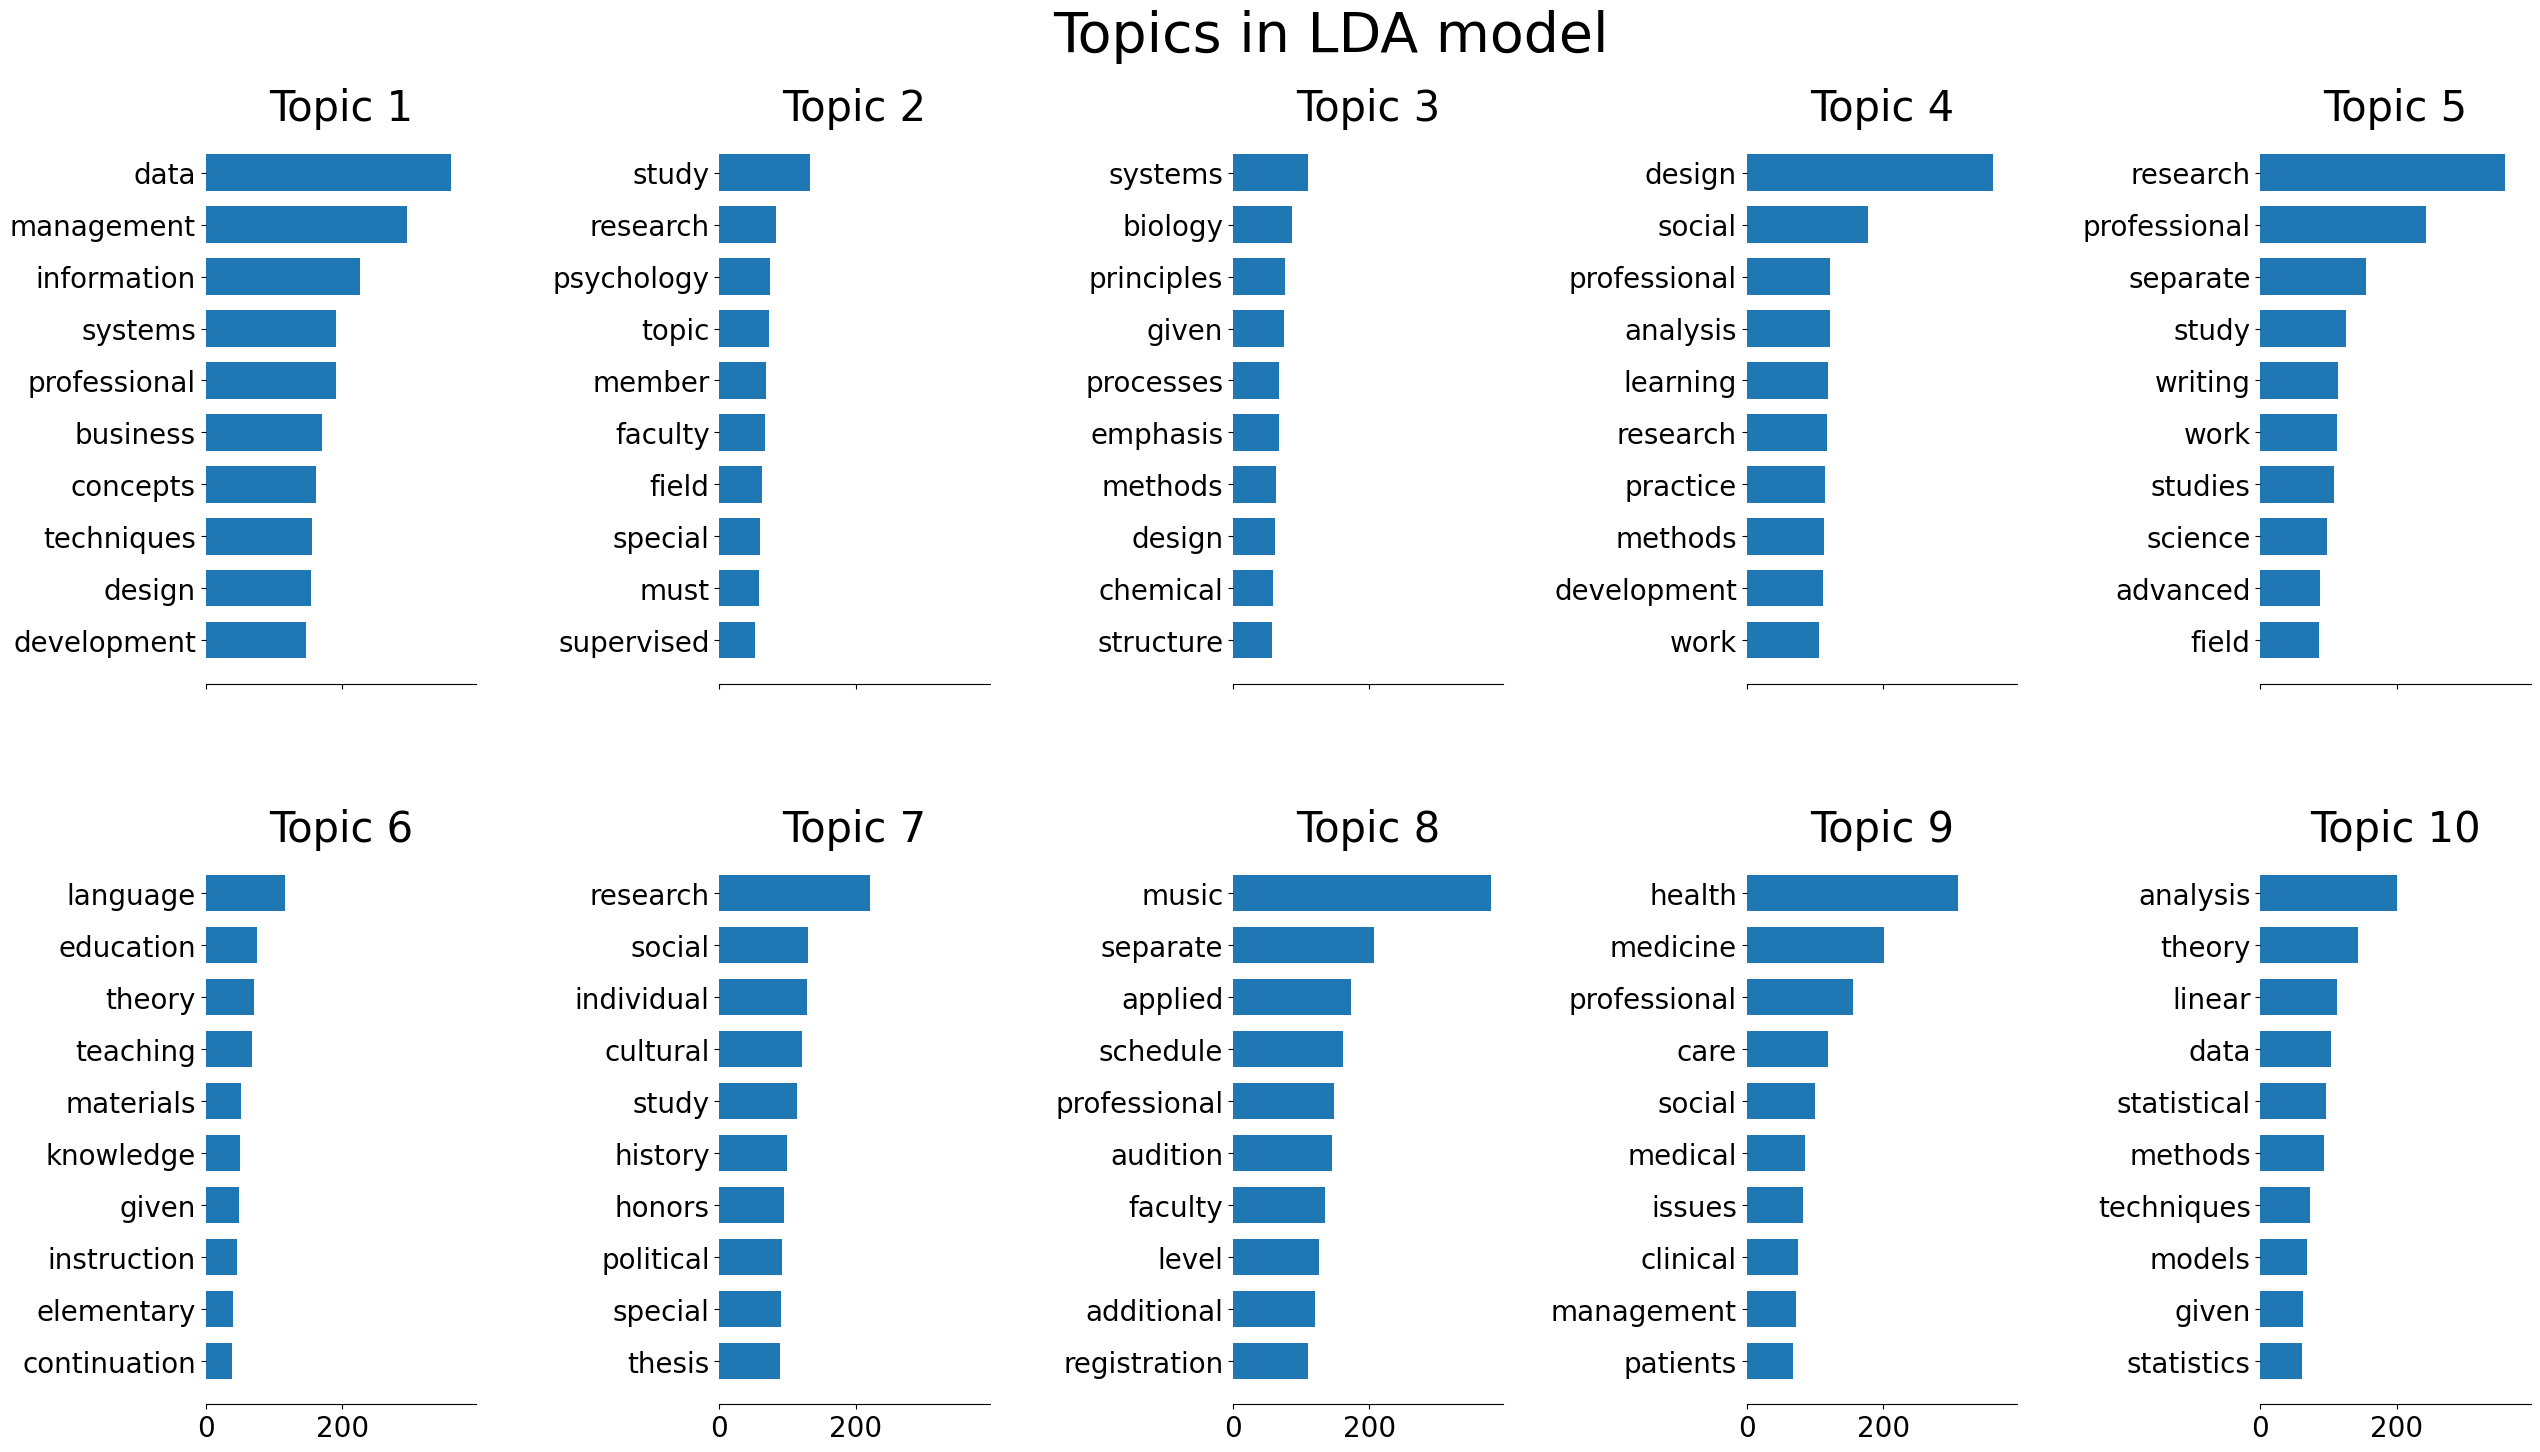

In [255]:
import matplotlib.pyplot as plt
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

plot_top_words(lda, count_vectorizer.get_feature_names_out(), no_top_words, 'Topics in LDA model')

In [253]:
# Make a new csv for each subject for topic modeling by department (subject)
# for subject in df['Subject'].unique():
#     subject_df = df[df['Subject'] == subject]
#     print(subject_df)